In [24]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mcvalue(m, mbin):
    density = np.histogram(m, range = (min(m) - 1, max(m) + 1), density=True)
    return density[1][np.argmax(density[0])]

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    """
    To calculate the L2 distance on the sphere
    """
    rad=np.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(np.sin(rad*dlat/2))**2 + np.cos(rad*lat1)*np.cos(rad*lat2)*(np.sin(rad*dlon/2))**2
    distancia=2*R*np.arcsin(np.sqrt(a))
    return distancia

In [35]:
def dist_quakes(catalogo, B, c, d):
    """
    Returns matrix with the distances between earthquakes. If the value is negative
    then earthquake i happened after earthquake j.
    The geographical distance used is the product metric (haversine^2 + L2^2)^1/2 (which
    won't be truthful for long distances)
    """
    distancias = np.zeros(shape=(catalogo.shape[0], catalogo.shape[0]))
    for i in range(catalogo.shape[0]):
        for j in range(i+1, catalogo.shape[0]):
            sismo_i = catalogo.iloc[i,:]
            sismo_j = catalogo.iloc[j,:]
            
            tau = sismo_j["timestamp"] - sismo_i["timestamp"]
            tau = tau.total_seconds() # The time scale will be in seconds
            
            r = np.sqrt(haversine(sismo_i["Longitud"], sismo_j['Longitud'],
                        sismo_i['Latitud'], sismo_j['Latitud'])**2 + 
                        (sismo_j['Profundidad']-sismo_i['Profundidad'])**2 )
            delta_m = sismo_j["Magnitud"] - sismo_i["Magnitud"]
            
            distancias[i,j] = c*tau* (r**d) *(10**(-B * delta_m))
             
    return distancias           

In [97]:
def dist_quakes_sparse(catalogo, B, c, d, max_cluster=1000):
    """
    Returns matrix with the distances between earthquakes. If the value is negative
    then earthquake i happened after earthquake j.
    The geographical distance used is the product metric (haversine^2 + L2^2)^1/2 (which
    won't be truthful for long distances)
    """
    lat=catalogo['Latitud'].to_numpy()
    long=catalogo['Longitud'].to_numpy()
    mag=catalogo["Magnitud"].to_numpy()
    time=((catalogo["timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).to_numpy()
    depth=catalogo['Profundidad'].to_numpy()
    distancias = np.zeros(shape=(catalogo.shape[0], max_cluster))
    for i in range(max_cluster):
        
        lat_shift= np.concatenate([np.zeros(i+1),lat[:-(i+1)]])
        long_shift=np.concatenate([ np.zeros(i+1),long[:-(i+1)]])
        mag_shift=np.concatenate([ np.zeros(i+1),mag[:-(i+1)]])
        time_shift=np.concatenate([np.zeros(i+1),time[:-(i+1)]])
        depth_shift=np.concatenate([ np.zeros(i+1),depth[:-(i+1)]])

            
        tau = time-time_shift
        r = np.sqrt(haversine(long, long_shift,
                        lat, lat_shift)**2 + 
                        (depth-depth_shift)**2 )

        delta_m = mag-mag_shift 
            
        distancias[:,i] = c*tau* (r**d) *(10**(-B * delta_m))
        distancias[:i,i]=np.infty 
        
        #print('finished shift =  ', str(i))
    return distancias     

In [19]:
sismos = pd.read_csv(".//SSNMX_catalogo_20170901_20210510_lat12d85_18d66_lon-97d26_-88d69.csv",  skiprows=4)
sismos= sismos.dropna()
sismos

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,2017-09-01,01:26:16,3.4,15.9832,-96.9505,25.8,"18 km al NORESTE de PUERTO ESCONDIDO, OAX",2017-09-01,06:26:16,revisado
1,2017-09-01,01:29:47,3.5,16.6938,-95.1257,94.8,"15 km al NORTE de CD IXTEPEC, OAX",2017-09-01,06:29:47,revisado
2,2017-09-01,02:10:55,3.8,15.5425,-92.4787,187.6,"32 km al NOROESTE de MOTOZINTLA, CHIS",2017-09-01,07:10:55,revisado
3,2017-09-01,02:15:28,3.5,16.0508,-97.1588,26.3,"23 km al NOROESTE de PUERTO ESCONDIDO, OAX",2017-09-01,07:15:28,revisado
4,2017-09-01,02:24:18,3.6,17.1730,-94.9790,121.0,"34 km al NORTE de MATIAS ROMERO, OAX",2017-09-01,07:24:18,revisado
...,...,...,...,...,...,...,...,...,...,...
54557,2021-05-10,02:10:19,3.8,15.9500,-95.6600,54.0,"54 km al NORESTE de CRUCECITA, OAX",2021-05-10,07:10:19,verificado
54558,2021-05-10,02:15:51,3.9,17.4100,-94.8400,144.0,"53 km al SUR de SAYULA DE ALEMAN, VER",2021-05-10,07:15:51,verificado
54559,2021-05-10,03:35:19,3.9,14.9200,-94.0200,14.0,"121 km al SUROESTE de PIJIJIAPAN, CHIS",2021-05-10,08:35:19,verificado
54560,2021-05-10,05:13:42,4.5,14.0000,-92.1500,43.0,"75 km al SUR de CD HIDALGO, CHIS",2021-05-10,10:13:42,verificado


In [21]:
sismos["timestamp"] = sismos['Fecha'] + ' ' +sismos['Hora']
sismos["timestamp"] = sismos["timestamp"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
sismos.drop(['Fecha UTC','Hora UTC', 'Estatus'], 1)

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,timestamp
0,2017-09-01,01:26:16,3.4,15.9832,-96.9505,25.8,"18 km al NORESTE de PUERTO ESCONDIDO, OAX",2017-09-01 01:26:16
1,2017-09-01,01:29:47,3.5,16.6938,-95.1257,94.8,"15 km al NORTE de CD IXTEPEC, OAX",2017-09-01 01:29:47
2,2017-09-01,02:10:55,3.8,15.5425,-92.4787,187.6,"32 km al NOROESTE de MOTOZINTLA, CHIS",2017-09-01 02:10:55
3,2017-09-01,02:15:28,3.5,16.0508,-97.1588,26.3,"23 km al NOROESTE de PUERTO ESCONDIDO, OAX",2017-09-01 02:15:28
4,2017-09-01,02:24:18,3.6,17.1730,-94.9790,121.0,"34 km al NORTE de MATIAS ROMERO, OAX",2017-09-01 02:24:18
...,...,...,...,...,...,...,...,...
54557,2021-05-10,02:10:19,3.8,15.9500,-95.6600,54.0,"54 km al NORESTE de CRUCECITA, OAX",2021-05-10 02:10:19
54558,2021-05-10,02:15:51,3.9,17.4100,-94.8400,144.0,"53 km al SUR de SAYULA DE ALEMAN, VER",2021-05-10 02:15:51
54559,2021-05-10,03:35:19,3.9,14.9200,-94.0200,14.0,"121 km al SUROESTE de PIJIJIAPAN, CHIS",2021-05-10 03:35:19
54560,2021-05-10,05:13:42,4.5,14.0000,-92.1500,43.0,"75 km al SUR de CD HIDALGO, CHIS",2021-05-10 05:13:42


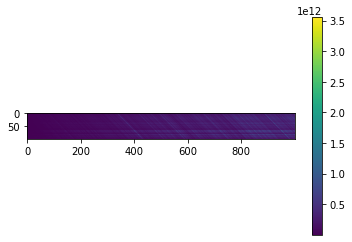

In [108]:
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
#d = len(m[m>0])
d = 2*B

#Arbitrary c. (We don't know what it is)
#We're also not entirely sure about the d. We need to find more sources.
dist_matrix=dist_quakes_sparse(sismos, B, 1, d)
plt.imshow(dist_matrix[-100:,:])
plt.colorbar()

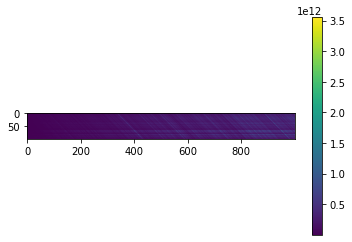

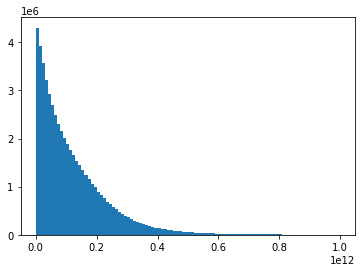

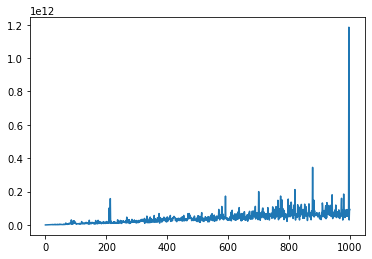

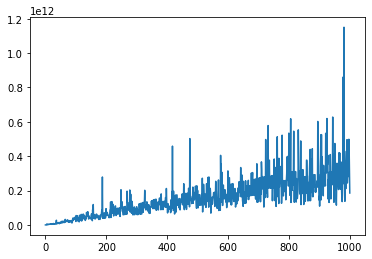

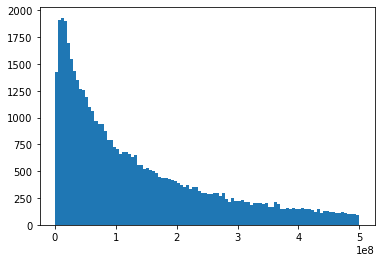

In [170]:
plt.imshow(dist_matrix[-100:,:])
plt.colorbar()
plt.show()
plt.hist(dist_matrix.flatten()[np.abs(dist_matrix.flatten())<1e12], bins =100)
plt.show() 
plt.plot(range(1000), dist_matrix[5000])
plt.show()
plt.plot(range(1000), dist_matrix[50000])
plt.show()

next_time=np.min(dist_matrix,axis=1)
plt.hist(next_time[next_time <5e8], bins =100)
plt.show()

In [183]:
#Nearest neighbour pairs
nn_dict={}
nn_numpy=np.zeros(sismos.shape[0])
for i in range(sismos.shape[0]):
    nn_numpy[i]=int(np.argmin(dist_matrix[i,:])+i+1)
    if np.min(dist_matrix[i,:])<0.5e8:
        nn_dict[i]=np.array([i,int(np.argmin(dist_matrix[i,:])+i+1)])
    else:
        nn_dict[i]={i}
        


In [184]:
nn_dict

{0: {0},
 1: array([1, 2]),
 2: {2},
 3: array([3, 4]),
 4: array([4, 5]),
 5: {5},
 6: {6},
 7: array([7, 8]),
 8: {8},
 9: array([ 9, 10]),
 10: {10},
 11: {11},
 12: {12},
 13: {13},
 14: {14},
 15: array([15, 16]),
 16: {16},
 17: {17},
 18: {18},
 19: {19},
 20: {20},
 21: {21},
 22: {22},
 23: {23},
 24: {24},
 25: {25},
 26: {26},
 27: {27},
 28: array([28, 29]),
 29: {29},
 30: array([30, 31]),
 31: {31},
 32: {32},
 33: array([33, 34]),
 34: {34},
 35: {35},
 36: array([36, 37]),
 37: {37},
 38: {38},
 39: {39},
 40: {40},
 41: {41},
 42: {42},
 43: {43},
 44: {44},
 45: {45},
 46: {46},
 47: {47},
 48: {48},
 49: {49},
 50: {50},
 51: {51},
 52: {52},
 53: {53},
 54: {54},
 55: {55},
 56: {56},
 57: {57},
 58: {58},
 59: {59},
 60: array([60, 61]),
 61: {61},
 62: {62},
 63: {63},
 64: {64},
 65: {65},
 66: {66},
 67: {67},
 68: {68},
 69: {69},
 70: array([70, 71]),
 71: {71},
 72: {72},
 73: array([73, 74]),
 74: {74},
 75: {75},
 76: {76},
 77: {77},
 78: {78},
 79: array(

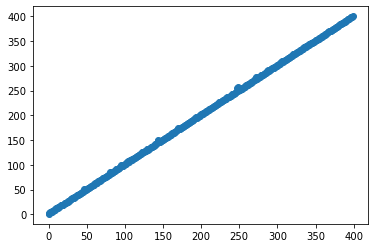

In [115]:
plt.scatter(range(sismos.shape[0])[:400],nn_numpy[:400] )

plt.show()

In [ ]:
def get_all_connected_groups(graph):
    already_seen = set()
    result = []
    for i in range(sismos.shape[0]):
        if i not in already_seen:
            connected_group, already_seen = get_connected_group(i, already_seen, graph)
            result.append(connected_group)
    return result

def get_connected_group(node, already_seen, graph):
        result = []
        check=True 
        while check:
            result.append(node)
            already_seen.add(node)
        if np.shape(graph[node])==(2,):
            node=graph[node][1]
        else:
            check=False 
        return result, already_seen
    
components = get_all_connected_groups(nn_dict)

In [139]:
np.shape(components)


(54562, 1)

In [189]:
np.shape(nn_dict[3])==(2,)

True